In [1]:
###########################
#   -*- coding: utf-8 -*- #
# PHM_data_challenge_2019 #
#     Author: Huet Zhu    #
#       Date:2019.5       #
#    All Rights Reserved  #
###########################

# # 基于机器学习的飞控系统故障诊断方案设计
from __future__ import division

import numpy as np
import xgboost as xgb
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

from scipy import sparse
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn import preprocessing
import printTime as pt
import gc

import warnings
import random
warnings.filterwarnings('ignore')

In [2]:
pt.printTime()

2019-08-21 14:35:20


In [3]:
age_test = pd.read_csv("../data/age_test.csv", header = None)
age_train = pd.read_csv("../data/age_train.csv", header = None)
user_app_usage = pd.read_csv("../data/user_app_usage.csv", nrows=500000, header = None)

In [4]:
# date_dict = {'2019-02-28': 0}
# for date in user_app_usage.loc[:, 4]:
#     if date not in date_dict:
#         date_dict[date] = int(date.split('-')[2])
date_dict = {}
i = 0
for one_day in tqdm(user_app_usage.loc[:, 4]):
    if one_day not in date_dict.keys():
        date_dict[one_day] = i
        i += 1
day_num = i
pt.printTime()
len(date_dict)

100%|██████████| 500000/500000 [00:00<00:00, 2025376.70it/s]

2019-08-21 14:35:21


30

In [5]:
user_app_usage = pd.read_csv("../data/user_app_usage.csv", header = None)

# 查找方差最大的app并依次展开

In [6]:
user_app_usage = user_app_usage.loc[user_app_usage[4] == '2019-03-03', :]
user_app_usage.shape

(22213813, 5)

In [7]:
age_train[0].values

array([1000001, 1000011, 1000015, ..., 3512498, 3512499, 3512500])

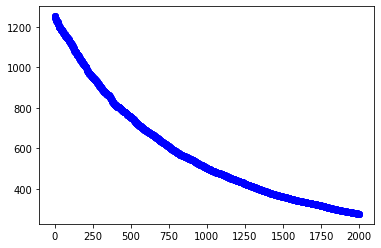

In [8]:
app_pd_import = user_app_usage.loc[:, 1].value_counts()
app_pd_import.to_csv('../processed/appid_active_count.csv')
app_pd_import = pd.read_csv("../processed/appid_active_count.csv", header = None)
plt.plot(range(2000), app_pd_import.loc[1000:2999, 1], 'b-o')  # 从下往上画
plt.show()

In [9]:
important_appid_topN = app_pd_import.loc[:, 0].values
age_appId_number_matrix = np.zeros((7, len(important_appid_topN)))

In [10]:
pt.printTime()

2019-08-21 14:42:13


In [11]:
age_train = age_train.values
age_test = age_test.values

In [12]:
uid_label_dict = {}
for i in range(age_train.shape[0]):
    uid_label_dict[age_train[i, 0]] = age_train[i, 1]
for i in range(age_test.shape[0]):
    uid_label_dict[age_test[i, 0]] = 0

In [13]:
pt.printTime()

2019-08-21 14:42:14


In [14]:
appid_dict = {}
for i in range(len(important_appid_topN)):
    appid_dict[important_appid_topN[i]] = i

In [15]:
user_app_usage = user_app_usage.values
user_app_usage[:5]

array([[1000364, 'a00289850', 731.0, 2.0, '2019-03-03'],
       [1000364, 'a00278858', 81.0, 29.0, '2019-03-03'],
       [1000364, 'a00289826', 148.0, 12.0, '2019-03-03'],
       [1000364, 'a00289791', 1018.0, 41.0, '2019-03-03'],
       [1000364, 'a00290027', 662.0, 5.0, '2019-03-03']], dtype=object)

In [16]:
for i in tqdm(range(user_app_usage.shape[0])):
    age_appId_number_matrix[uid_label_dict[user_app_usage[i, 0]], appid_dict[user_app_usage[i, 1]]] += 1

100%|██████████| 22213813/22213813 [00:29<00:00, 754809.42it/s]


In [17]:
age_appId_number_matrix = np.delete(age_appId_number_matrix, 0, axis = 0)

In [18]:
age_appId_number_matrix.shape

(6, 179461)

In [19]:
age_test = pd.read_csv("../data/age_test.csv", header = None)
age_train = pd.read_csv("../data/age_train.csv", header = None)
ageNumber = age_train[1].value_counts()
ageNumber

3    600000
4    500000
2    400000
5    300000
6    150000
1     60000
Name: 1, dtype: int64

In [20]:
age_appId_number_matrix[0] = age_appId_number_matrix[0]/ageNumber[1]
age_appId_number_matrix[1] = age_appId_number_matrix[1]/ageNumber[2]
age_appId_number_matrix[2] = age_appId_number_matrix[2]/ageNumber[3]
age_appId_number_matrix[3] = age_appId_number_matrix[3]/ageNumber[4]
age_appId_number_matrix[4] = age_appId_number_matrix[4]/ageNumber[5]
age_appId_number_matrix[5] = age_appId_number_matrix[5]/ageNumber[6]
age_appId_number_matrix = pd.DataFrame(age_appId_number_matrix,columns=appid_dict.keys())
# age_appId_number_matrix.describe()

In [21]:
app_stds = age_appId_number_matrix.std()
app_stds.sort_values(ascending=False,inplace=True)
age_appId_number_matrix = age_appId_number_matrix.reindex(columns=app_stds.keys())

In [22]:
# age_appId_number_matrix.describe()

In [23]:
app_keys = age_appId_number_matrix.keys()
app_keys

Index(['a00289826', 'a00292780', 'a00224427', 'a00278905', 'a00292472',
       'a00290027', 'a00290015', 'a00274701', 'a00271087', 'a00481059',
       ...
       'a00314936', 'a00406507', 'a00198232', 'a00259445', 'a00332593',
       'a00164847', 'a00484140', 'a00258515', 'a00148241', 'a00327602'],
      dtype='object', length=179461)

In [24]:
np.savetxt('../processed/high_attractive_app_keys.txt',app_keys, fmt='%s', delimiter=',', newline='\n')

In [25]:
pt.printTime()

2019-08-21 14:42:48


# 生成5000维APP及其点击次数样本

In [26]:
###########################
#   -*- coding: utf-8 -*- #
# PHM_data_challenge_2019 #
#     Author: Huet Zhu    #
#       Date:2019.5       #
#    All Rights Reserved  #
###########################

# # 基于机器学习的飞控系统故障诊断方案设计
from __future__ import division

import numpy as np
import xgboost as xgb
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

from scipy import sparse
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn import preprocessing
import printTime as pt

import warnings
import random
warnings.filterwarnings('ignore')

In [27]:
pt.printTime()

2019-08-21 14:42:48


In [28]:
age_test = pd.read_csv("../data/age_test.csv", header = None)
age_train = pd.read_csv("../data/age_train.csv", header = None)

In [29]:
app_keys = np.loadtxt('../processed/high_attractive_app_keys.txt', dtype=str, delimiter=',')

all_users = pd.merge(age_train.drop([1], axis = 1), age_test, on=0, how='outer')
all_users = all_users.values
uid_index_dict = {}
index = 0
for uid in all_users:
    uid_index_dict[int(uid)] = index 
    index += 1

important_appid_topN = app_keys[:5000]
important_appid_topN = important_appid_topN.tolist()

add_columns = np.zeros((all_users.shape[0], len(important_appid_topN)))
appid_dict = {}
for i in range(len(important_appid_topN)):
    appid_dict[important_appid_topN[i]]=i
important_appid_topN = set(important_appid_topN)

In [30]:
# user_app_usage = pd.read_csv("../data/user_app_usage.csv", nrows=500000, header = None)
# user_app_usage = pd.read_csv("../data/user_app_usage.csv", header = None)
# user_app_usage = user_app_usage.values
# user_app_usage = np.loadtxt('../data/user_app_usage.csv', dtype=str, delimiter=',',  usecols=(0, 1, 3), skiprows=1, comments='#')

In [31]:
for i in tqdm(range(user_app_usage.shape[0])):
    if user_app_usage[i, 1] in important_appid_topN:
        row = uid_index_dict[user_app_usage[i, 0]]
        clum = appid_dict[user_app_usage[i, 1]]
        times = user_app_usage[i, 3]
        if times > 675:
            add_columns[row, clum] += 675
        else:
            add_columns[row, clum] += times

100%|██████████| 22213813/22213813 [00:43<00:00, 506752.94it/s]


In [32]:
del user_app_usage
gc.collect()

2526

In [33]:
add_columns = csr_matrix(add_columns)

In [34]:
# add_columns = csr_matrix(add_columns)
scale = preprocessing.MaxAbsScaler()
add_columns = scale.fit_transform(add_columns)
gc.collect()
pt.printTime()

2019-08-21 14:45:20


In [35]:
trainData = add_columns[:2010000]
testData = add_columns[2010000:]
sparse.save_npz('../trainTestData/trainData5000.npz', trainData)  #保存
sparse.save_npz('../trainTestData/testData5000.npz', testData)  #保存

In [36]:
testData.shape, testData.shape

((502500, 5000), (502500, 5000))

In [37]:
pt.printTime()

2019-08-21 14:45:36
